# Data Analysis

In [ ]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Load your sequential data of electricity demand
# Assuming your data is in a CSV file, with 'demand' column representing the electricity demand
data = pd.read_csv("./data/NET.csv")
data['Target'] = data['Net Demand']
data

,Date,Period,Total Demand,TCQ,Net Demand,Target
0,2023-07-01,1,6119.563,486.146668,5633.416332,5633.416332
1,2023-07-01,2,6019.671,486.146668,5533.524332,5533.524332
2,2023-07-01,3,5910.691,486.146668,5424.544332,5424.544332
3,2023-07-01,4,5843.399,486.146668,5357.252332,5357.252332
4,2023-07-01,5,5797.707,486.146668,5311.560332,5311.560332
...,...,...,...,...,...,...
12892,2024-03-25,29,6979.539,355.818726,6623.720274,6623.720274
12893,2024-03-25,30,7042.605,355.818726,6686.786274,6686.786274
12894,2024-03-25,31,7067.406,355.818726,6711.587274,6711.587274
12895,2024-03-25,32,7121.950,355.818726,6766.131274,6766.131274


## Exploratory Data Analysis

### Distribution and Summary

Net demand distribution

In [ ]:
data['Target'].describe()

count    12897.000000
mean      5918.388377
std        553.455214
min       4689.052462
25%       5415.945392
50%       5951.263274
75%       6430.627237
max       7000.195237
Name: Target, dtype: float64

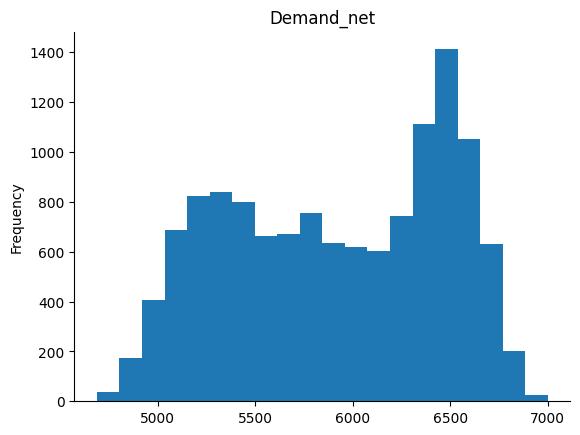

In [ ]:
import matplotlib
from matplotlib import pyplot as plt
data['Target'].plot(kind='hist', bins=20, title='Demand_net')
plt.gca().spines[['top', 'right',]].set_visible(False)

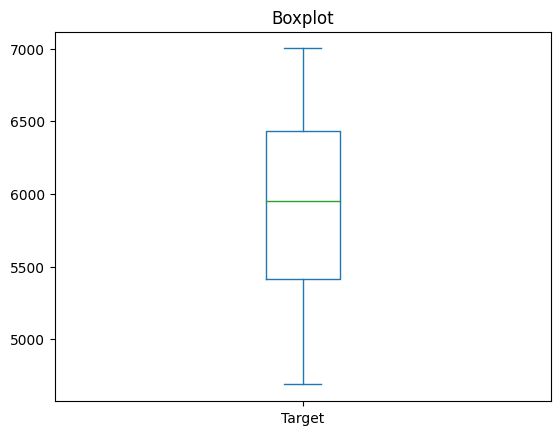

In [ ]:
data['Target'].plot.box(title='Boxplot');

Distribution of Net Demand and period

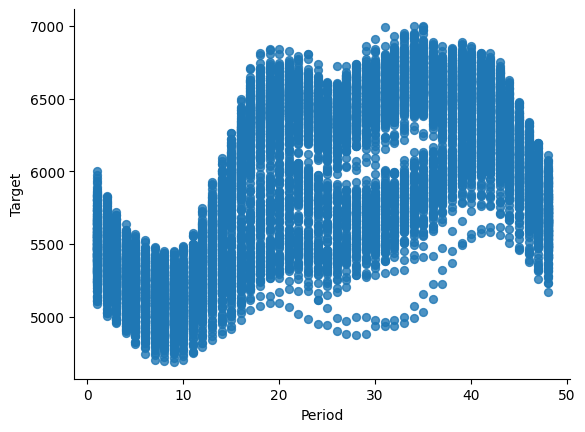

In [ ]:
data.plot(kind='scatter', x='Period', y='Target', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

Total time series

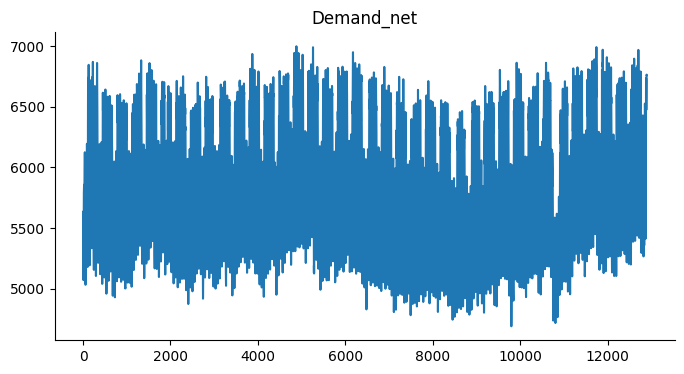

In [ ]:
data['Target'].plot(kind='line', figsize=(8, 4), title='Demand_net')
plt.gca().spines[['top', 'right']].set_visible(False)

### Auto-correlation Check

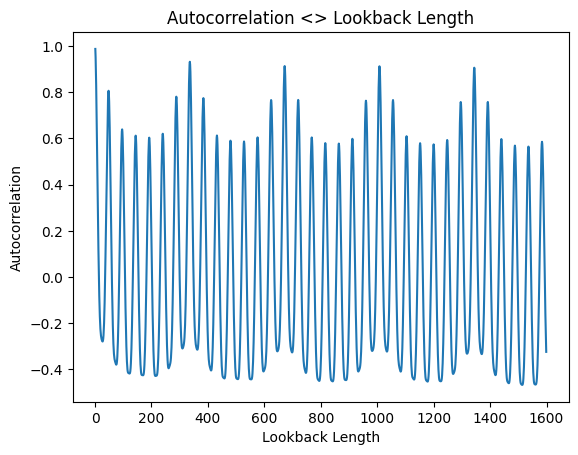

Best Lookback Length: 336


In [ ]:
# Calculate autocorrelation for different lookback lengths
lookback_lengths = range(1, 1600)
autocorrelation_values = []
for lookback in lookback_lengths:
  autocorrelation = data['Target'].autocorr(lag=lookback)
  autocorrelation_values.append(autocorrelation)

# Plot autocorrelation values
plt.plot(lookback_lengths, autocorrelation_values)
plt.xlabel('Lookback Length')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation <> Lookback Length')
plt.show()

# Sort the autocorrelation values in descending order
sorted_autocorrelation_values = sorted(autocorrelation_values, reverse=True)

best_lookback_length = max([lookback for lookback in lookback_lengths if lookback > 10], key=lambda x: autocorrelation_values[x-1])
print('Best Lookback Length:', best_lookback_length)


### Staionry Test

Augmented Dickey-Fuller test:

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Target'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.926941
p-value: 0.000031
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

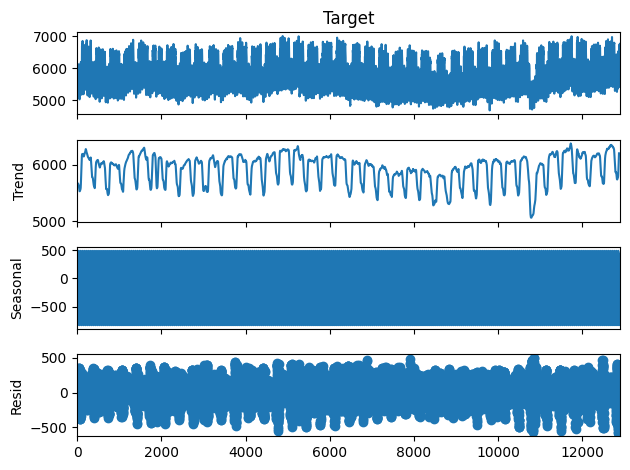

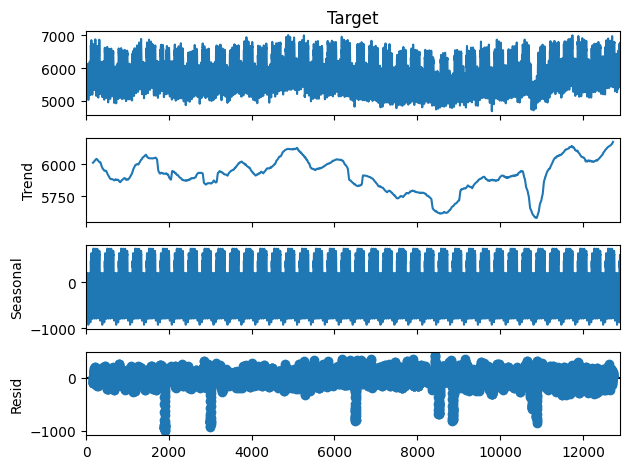

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result1 = seasonal_decompose(data['Target'], model='additive', period=48)
result2 = seasonal_decompose(data['Target'], model='additive', period=336)
result1.plot()
result2.plot()
plt.show()

First Image (48 Periods)
In the first image, if the seasonal decomposition is calculated with a period of 1, this likely means that seasonality is being assessed at a granularity that does not correspond to any expected seasonal cycle (e.g., daily, weekly). Given there are 48 half-hour periods in a day, a period=48 might be more appropriate to capture daily seasonality. The components are:

Trend: This captures changes over the series that are more gradual. In this decomposition, the trend appears relatively flat, which suggests that over the periods shown, there isn't a clear increasing or decreasing trend in the data.

Seasonal: This is essentially a flat line, which indicates that the model did not detect any seasonality given the period of 1. This is not surprising since the chosen period does not align with any natural seasonality in the data.

Residual: The residuals appear to be the bulk of the data, showing that without a proper seasonal and trend component being extracted, most of the data is left unexplained, coming out as noise or irregular fluctuations.

Second Image (336 Periods)
In the second image, if the seasonal decomposition is calculated with a period that's suggested to be 336, this would imply that the seasonal cycle is expected to be weekly (336 half-hour periods equate to 7 days). The components are:

Trend: The trend component shows more variation over time compared to the first image, suggesting that when accounting for weekly cycles, there is a noticeable trend within each week.

Seasonal: The seasonality component has a clear pattern, likely capturing the weekly cycle. This repeating pattern every 336 periods indicates a strong weekly seasonality in the data.

Residual: The residuals in this decomposition are less chaotic than in the first image, suggesting that much of the variability in the data can be explained by the trend and weekly seasonality.

### Distribution Check for scaling

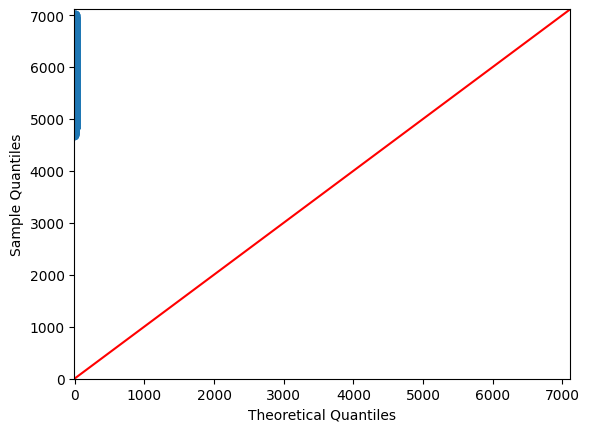

In [ ]:
import statsmodels.api as sm
sm.qqplot(data['Target'], line='45')
plt.show()

In [ ]:
from scipy.stats import normaltest
stat, p = normaltest(data['Target'])
# Interpretation
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')


Sample does not look Gaussian (reject H0)


Apply the Robust Scaler using interquartile range

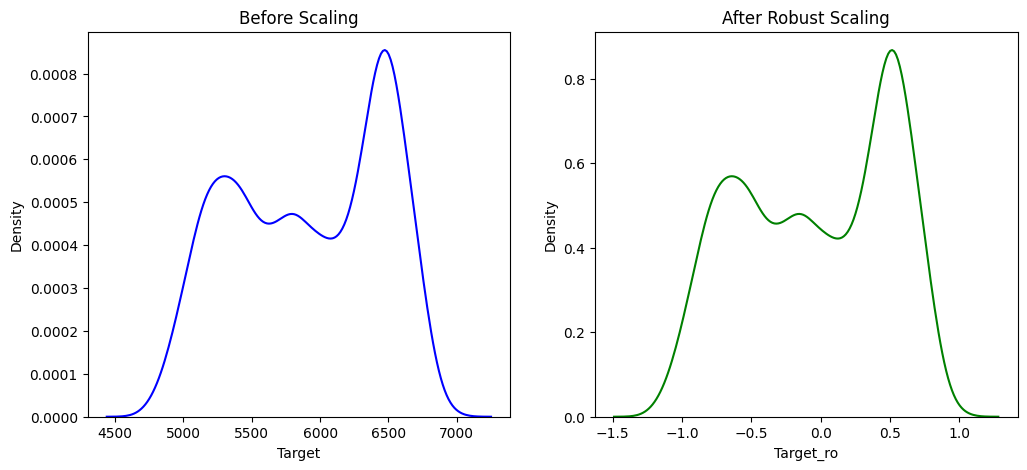

In [ ]:
from sklearn.preprocessing import RobustScaler
import seaborn as sns
# Reshape your data['Target'] to a 2D array
target_reshaped = data['Target'].values.reshape(-1, 1)

# Initialize the RobustScaler
scaler = RobustScaler()

# Fit the RobustScaler to the data
scaler.fit(target_reshaped)

# Transform the data using the fitted scaler
data['Target_ro'] = scaler.transform(target_reshaped)

# Plotting the distributions before and after scaling
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Before Scaling
sns.kdeplot(data['Target'], ax=ax1, color='blue')
ax1.set_title('Before Scaling')

# After Scaling
sns.kdeplot(data['Target_ro'].squeeze(), ax=ax2, color='green')  # .squeeze() changes it from 2D back to 1D for plotting
ax2.set_title('After Robust Scaling')

plt.show()